# Data Analysis for _Illusory Tempo - Motor_ and _Illusory Tempo - Motor Split Range_

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as stats

In [3]:
FIGURE_PATH = 'figures/'
THEME = 'light'

if THEME == 'dark':
    background_color = '#151619'
    text_color = 'w'
    color1 = '#90E6E2'
    color2 = '#FAB2B9'
else:
    background_color = 'w'
    text_color = 'k'
    color1 = '#78290f'
    color2 = '#15616d'

plt.rcParams.update({
    # BACKGROUND
    'figure.facecolor': background_color, 
    'axes.facecolor': background_color, 
    'savefig.facecolor': background_color,
    
    # TEXT
    'text.color': text_color,
    'axes.labelcolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color,
    'figure.titlesize': 28,  # fontsize of the figure title
    'axes.titlesize': 28,
    'axes.labelsize': 28,  # fontsize of the x and y labels
    'xtick.labelsize': 23,  # fontsize of the tick labels
    'ytick.labelsize': 23,  # fontsize of the tick labels
    'legend.fontsize': 16,  # legend fontsize
    'legend.title_fontsize': 18,  # legend title size
    
    # FIGURE STYLE
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.edgecolor': text_color,
    'axes.grid': False,
    'ytick.left': True,
    'xtick.bottom': True
})

## Load processed data from all participants

In [5]:
DATAFILE = '../processed_data/processed_taps.csv'

data = pd.read_csv(DATAFILE, low_memory=False)
data.subject = data.subject.astype(str)
data.ioi = data.ioi.astype(int).astype(str)
data.usable = data.usable.astype(bool)

## Load musical training data

In [7]:
MUSFILE = '../processed_data/musicianship.csv'
mdata = pd.read_csv(MUSFILE)

mdata.rename(columns=dict(ID='subject'), inplace=True)
mdata.subject = mdata.subject.astype(str)
for col in ('Wind', 'Piano', 'Strings', 'Percussion', 'Vocals'):
    mdata.loc[mdata[col] == 'yes', col] = True
    mdata.loc[mdata[col] == 'no', col] = False

# Merge 
data = data.merge(mdata, how='left', on='subject')
data.loc[np.isnan(data.Age), 'years_lessons'] = 0

## Exclude participants identified as outliers during data review

In [9]:
# PARTICIPANT EXCLUSION
# S9 had outlier mean sync phase of about 3/4 pi, indicating either anti-phase synchronization or reacting to tones
# S14 had low mean resultant vector length (poor synchronization) and tapped faster than relative ITI of 3/4 in 600 ms condition
# S52 had low mean resultant vector length (poor synchronization) and tapped slower than a rel. ITI of 4/3 in 400 ms condition
# S53 tapped faster than relative ITI of 3/4 in 600 ms condition
# S95 tapped faster than relative ITI of 3/4 in 600 ms condition
# S99 had low mean resultant vector length (poor synchronization) and tapped slower than a rel. ITI of 4/3 in 400 ms condition
excluded = ['9', '14', '52', '53', '95', '99']
# S58 bad in block 1 only, S82 and S94 bad in first 2 blocks only
data = data[~((data.subject == '58') & (data.block == 1))]
data = data[~((data.subject == '82') & (data.block <= 2))]
data = data[~((data.subject == '94') & (data.block <= 2))]
data = data[~np.isin(data.subject, excluded)]

## Create Arduino tapping "blind spot" example figure
For illustrative purposes, we just use intervals 3-7 from Experiment 1 trials with a 400 ms IOI. Note that on interval 8, you actually *can* detect taps with an onset of 392-399 ms because the Arduino is waiting to trigger the first continuation tone in response.

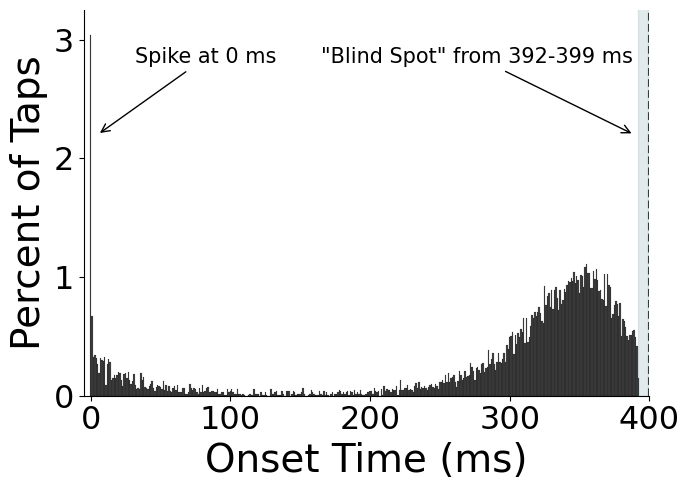

In [11]:
blindspot_example_data = data[(data.experiment == 'ITM') & (data.interval_number >= 3) & (data.interval_number <= 7) & (data.ioi == '400')].copy()
sns.histplot(data=blindspot_example_data, x=blindspot_example_data.tap_phase * 200 / np.pi, stat='percent', discrete=True, element='bars', color=text_color)
plt.fill_betweenx(y=(0, 10), x1=392, x2=399, color=color2, alpha=.125)
plt.axvline(400, ls='--', c='k', alpha=.75)
plt.annotate('"Blind Spot" from 392-399 ms', xy=(389, 2.2), xytext=(165, 2.8),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15)
plt.annotate('Spike at 0 ms', xy=(5, 2.2), xytext=(32, 2.8),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15)
plt.xlabel('Onset Time (ms)')
plt.ylabel('Percent of Taps')
plt.ylim(0, 3.25)
plt.xlim(-5, 400)
plt.gcf().set_size_inches(7, 5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'blindspot_example.svg')
plt.savefig(FIGURE_PATH + 'blindspot_example.pdf')

## Exclude unusable taps and split data into synchronization versus continuation taps

In [13]:
# Fraction of eighth-interval taps excluded for phase > 2*pi
print(np.mean(data[(data.interval_number == 8) & (data.experiment == 'ITM')].tap_phase > 2 * np.pi))
print(np.mean(data[(data.interval_number == 8) & (data.experiment == 'ITMSR')].tap_phase > 2 * np.pi))

# Fraction of sync taps with possibly incorrect relative phase of 0
print(np.mean((data[(data.interval_number >= 3) & (data.interval_number <= 8) & (data.experiment == 'ITM')].tap_phase == 0)))
print(np.mean((data[(data.interval_number >= 3) & (data.interval_number <= 8) & (data.experiment == 'ITMSR')].tap_phase == 0)))

# Fraction of continuation taps excluded for outlier intervals
print(np.mean(data[(data.interval_number >= 9) & (data.interval_number <= 23) & (data.experiment == 'ITM')].rel_iti < 1/2))
print(np.mean(data[(data.interval_number >= 9) & (data.interval_number <= 23) & (data.experiment == 'ITM')].rel_iti > 2))
print(np.mean(data[(data.interval_number >= 9) & (data.interval_number <= 23) & (data.experiment == 'ITMSR')].rel_iti < 1/2))
print(np.mean(data[(data.interval_number >= 9) & (data.interval_number <= 23) & (data.experiment == 'ITMSR')].rel_iti > 2))

# Overall fraction of taps excluded
print(1-np.mean((data[(data.interval_number >= 3) & (data.interval_number <= 8) & (data.experiment == 'ITM')].usable)))
print(1-np.mean((data[(data.interval_number >= 3) & (data.interval_number <= 8) & (data.experiment == 'ITMSR')].usable)))

0.07306201550387596
0.08279325988334413
0.025175860792299148
0.020479134466769706
0.0007682130510861679
0.0011096410737911314
0.003357760550437098
0.001967529866396475
0.0396890040725657
0.03617286886220428


In [14]:
# Exclude unusable taps
data = data[data.usable]

In [15]:
# Split synchronization and continuation into separate tables
sdata = data[(data.interval_number >= 3) & (data.interval_number <= 8)].copy().reset_index()  # Analyze all sync taps after the 3rd tone
cdata = data[(data.interval_number >= 9) & (data.interval_number <= 23)].copy().reset_index()  # Analyze all continuation taps after the 9th tone (1st continuation tone)

## Preprocessing: Synchronization Tapping

We want to estimate which tone each synchronization tap was targeted at, in order to translate phases into asynchronies. Because all included participants' mean phases were in the range [$\pi$, $2\pi$), we can assume they were generally anticipating tones. Under this assumption:
1) The mean phase and any taps up to half a cycle earlier than that should be understood as negative asynchronies associated with the tone that ended the interval.
2) Taps more half a cycle earlier than their mean phase should be understood as positive asynchronies associated with the tone that started the interval.

We can apply this assumption by subtracting $2\pi$ from all phases in the range [$\mu-\pi$, $2\pi$).

This method gives a normal distribution of phases relative to the tone they were most likely targeted at. From there we can safely treat these phase values as non-circular, **as long as the width of a person's distribution is less than $2\pi$** (otherwise, it cannot be estimated with high confidence which tone each tap was targeted at). Based on the Data Review figures, the vast majority of participants do have a "dead zone" between the two tails of their phase distribution.

We can also convert these adjusted phases, $\phi$, to millisecond asynchronies by the formula $a = \frac{\phi}{2\pi} * IOI$.



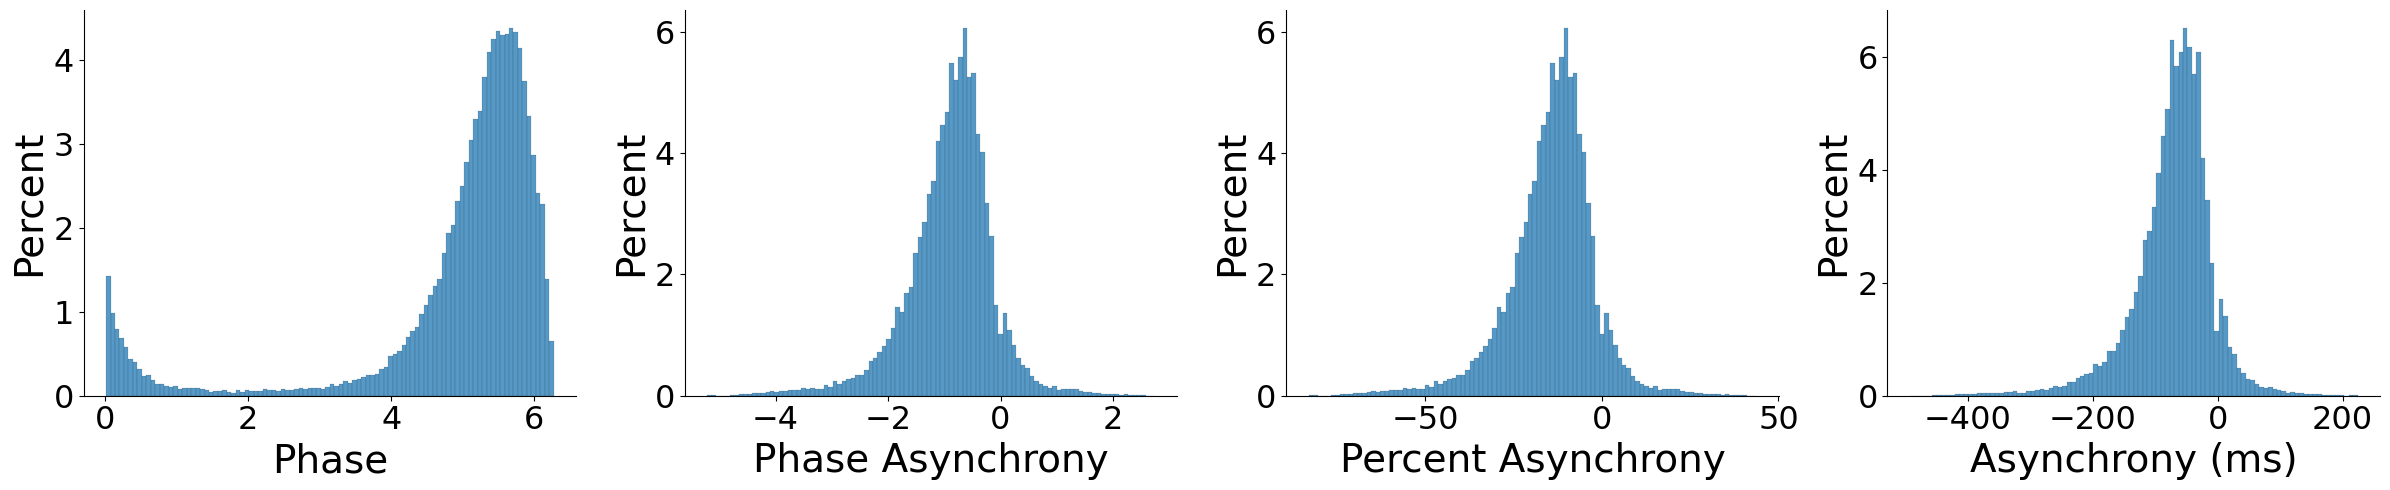

In [17]:
# Set up new columns
sdata['tone_number'] = sdata.interval_number
sdata['phase_async'] = sdata.tap_phase
sdata['perc_async'] = np.zeros(len(sdata.tap_phase))
sdata['ms_async'] = np.zeros(len(sdata.tap_phase))

# Convert phases to be relative to the tone they were most likely targeted at, rather than always the preceding tone
for i, subj in enumerate(sdata.subject.unique()):
    subj_mask = sdata.subject == subj

    # Find the circular mean of the participant's tapping phases
    subj_circmean = stats.circmean(sdata.loc[subj_mask, 'tap_phase'])

    # Find all taps up to half a cycle before the mean
    threshold = subj_circmean - np.pi
    threshold_mask = sdata.tap_phase >= threshold

    # Treat those taps as if they were tied to the tone at the end of the interval rather than the one at the start
    sdata.loc[subj_mask & threshold_mask, 'tone_number'] += 1
    sdata.loc[subj_mask & threshold_mask, 'phase_async'] -= 2 * np.pi

# Convert tap phases to percent and millisecond asynchronies
sdata.loc[:, 'perc_async'] = 100 * sdata.phase_async / (2 * np.pi)
sdata.loc[:, 'ms_async'] = sdata.ioi.astype(float) * sdata.phase_async / (2 * np.pi)

# Save processed synchronization tap dataset
sdata.to_csv('../processed_data/sync_data.csv', index=False)

# Illustrate the effect of this transformation
plt.subplot(141)
sns.histplot(data=sdata, x='tap_phase', stat='percent', bins=100)
plt.xlabel('Phase')
plt.subplot(142)
sns.histplot(data=sdata, x='phase_async', stat='percent', bins=100)
plt.xlabel('Phase Asynchrony')
plt.subplot(143)
sns.histplot(data=sdata, x='perc_async', stat='percent', bins=100)
plt.xlabel('Percent Asynchrony')
plt.subplot(144)
sns.histplot(data=sdata, x='ms_async', stat='percent', bins=100)
plt.xlabel('Asynchrony (ms)')
plt.gcf().set_size_inches(24, 5)
plt.tight_layout()

## Generate asynchrony calculation figure for one example participant

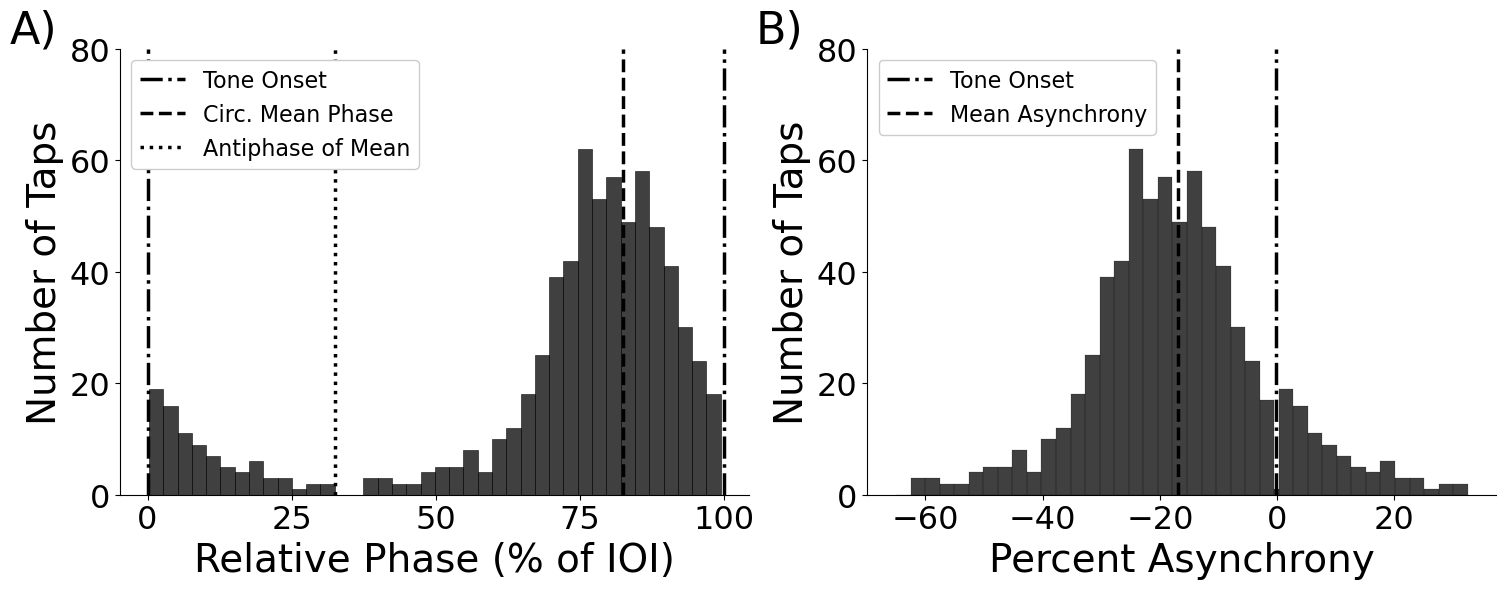

In [19]:
subj_mask = sdata.subject == '13'
subj_circmean = stats.circmean(sdata.loc[subj_mask, 'tap_phase'])
bins = np.histogram(sdata[subj_mask].tap_phase, bins=40)[1]
plt.subplot(121)
plt.text(-1.5, 81, 'A)', fontsize=32)
sns.histplot(data=sdata[subj_mask].tap_phase, bins=bins, color=text_color)
plt.axvline(0, ls='-.', c=text_color, lw=2.5, label='Tone Onset')
plt.axvline(subj_circmean, ls='--', c=text_color, lw=2.5, label='Circ. Mean Phase')
plt.axvline(subj_circmean - np.pi, ls=':', c=text_color, lw=2.5, label='Antiphase of Mean')
plt.axvline(2 * np.pi, ls='-.', lw=2.5, c=text_color)
plt.xlabel('Relative Phase (% of IOI)')
plt.xticks(np.arange(0, 2*np.pi+.001, np.pi*.5), ['0', '25', '50', '75', '100'])
plt.ylabel('Number of Taps')
plt.ylim(0, 80)
plt.legend(loc='upper left', framealpha=1)

# Convert bin positions from phases to asynchronies
threshold = subj_circmean - np.pi
threshold_mask = sdata.tap_phase >= threshold
bins[bins > threshold] -= 2 * np.pi
bins = np.sort(100 * bins / (2 * np.pi))

plt.subplot(122)
plt.text(-89, 81, 'B)', fontsize=32)
sns.histplot(data=sdata[subj_mask].perc_async, bins=bins, color=text_color)
plt.axvline(-.125, ls='-.', c=text_color, lw=2.5, label='Tone Onset')
plt.axvline(np.mean(sdata[subj_mask].perc_async), ls='--', c=text_color, lw=2.5, label='Mean Asynchrony')
plt.xlabel('Percent Asynchrony')
plt.ylabel('Number of Taps')
plt.ylim(0, 80)
plt.legend(loc='upper left', framealpha=1)

plt.gcf().set_size_inches(15, 6)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'sync_processing.svg')
plt.savefig(FIGURE_PATH + 'sync_processing.pdf')

### Apply the Loftus & Masson (1994) method to give us within-subject error bars on our figures.

In [21]:
async_means = sdata.groupby(['register', 'subject', 'pitch', 'ioi']).perc_async.mean().reset_index()
subj_means = async_means.groupby(['register', 'subject']).perc_async.mean().reset_index()
grand_means = subj_means.groupby('register').perc_async.mean().reset_index()

for i, subj in enumerate(subj_means.subject):
    reg_idx = np.where(grand_means.register == subj_means.register[i])[0]
    subj_mask = async_means.subject == subj
    async_means.loc[subj_mask, 'perc_async'] -= subj_means.loc[i, 'perc_async']
    async_means.loc[subj_mask, 'perc_async'] += grand_means.loc[reg_idx, 'perc_async'].iloc[0]

## Preprocessing: Continuation Tapping

In [23]:
# Save processed continuation tap dataset
cdata.to_csv('../processed_data/cont_data.csv', index=False)

### Apply the Loftus & Masson (1994) method to give us within-subject error bars on our figures.

In [25]:
iti_means = cdata.groupby(['register', 'subject', 'pitch', 'ioi']).rel_iti.mean().reset_index()
subj_means = iti_means.groupby(['register', 'subject']).rel_iti.mean().reset_index()
grand_means = subj_means.groupby('register').rel_iti.mean().reset_index()

for i, subj in enumerate(subj_means.subject):
    reg_idx = np.where(grand_means.register == subj_means.register[i])[0]
    subj_mask = iti_means.subject == subj
    iti_means.loc[subj_mask, 'rel_iti'] -= subj_means.loc[i, 'rel_iti']
    iti_means.loc[subj_mask, 'rel_iti'] += grand_means.loc[reg_idx, 'rel_iti'].iloc[0]

## Generate main data figures

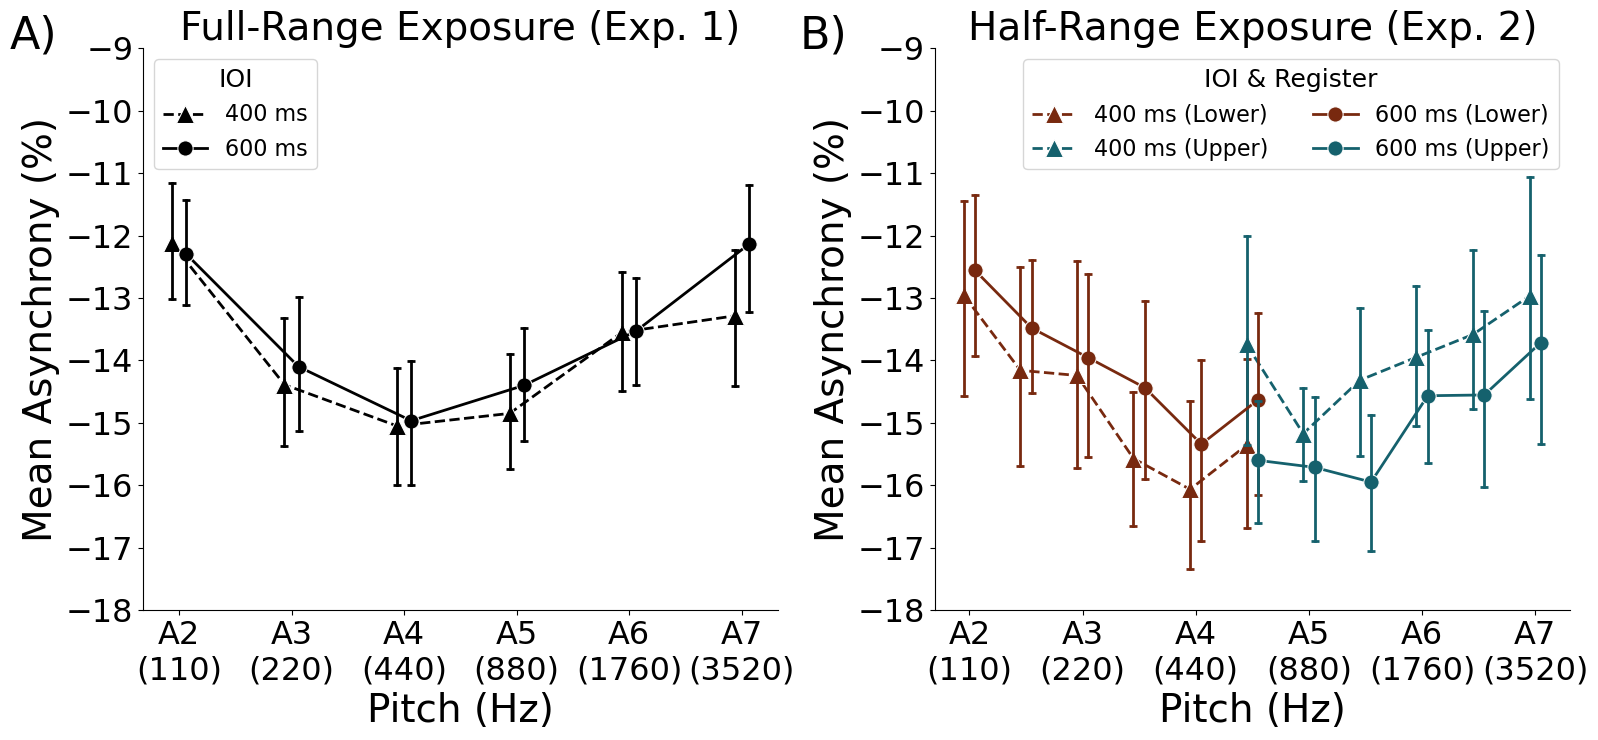

In [27]:
###
# SYNCHRONIZATION
###

plt.subplot(121)

# Plot data
d = async_means[(async_means.register=='B') & (async_means.ioi=='400')]
sns.lineplot(x=d.pitch-.75, y='perc_async', data=d, color=text_color, ls='--', marker='^', lw=2, ms=13, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms')
d = async_means[(async_means.register=='B') & (async_means.ioi=='600')]
sns.lineplot(x=d.pitch+.75, y='perc_async', data=d, color=text_color, ls='-', marker='o', lw=2, ms=11, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='600 ms')

# Formatting
plt.text(27, -9, 'A)', fontsize=32)
plt.title('Full-Range Exposure (Exp. 1)')
plt.legend(loc='upper left', title='IOI')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Mean Asynchrony (%)')
plt.ylim(-18, -9)
plt.yticks(np.arange(-18, -8, 1))


plt.subplot(122)

# Plot data
d = async_means[(async_means.register=='L') & (async_means.ioi=='400')]
sns.lineplot(x=d.pitch-.6, y='perc_async', data=d, color=color1, ls='--', marker='^', ms=13, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms (Lower)')
d = async_means[(async_means.register=='U') & (async_means.ioi=='400')]
sns.lineplot(x=d.pitch-.6, y='perc_async', data=d, color=color2, ls='--', marker='^', ms=13, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms (Upper)')
d = async_means[(async_means.register=='L') & (async_means.ioi=='600')]
sns.lineplot(x=d.pitch+.6, y='perc_async', data=d, color=color1, ls='-', marker='o', ms=11, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='600 ms (Lower)')
d = async_means[(async_means.register=='U') & (async_means.ioi=='600')]
sns.lineplot(x=d.pitch+.6, y='perc_async', data=d, color=color2, ls='-', marker='o', ms=11, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='600 ms (Upper)')


# Formatting
plt.text(27, -9, 'B)', fontsize=32)
plt.title('Half-Range Exposure (Exp. 2)')
plt.legend(loc='upper right', title='IOI & Register', ncol=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Mean Asynchrony (%)')
plt.ylim(-18, -9)
plt.yticks(np.arange(-18, -8, 1))


plt.gcf().set_size_inches(16, 7.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'async.svg')
plt.savefig(FIGURE_PATH + 'async.pdf')

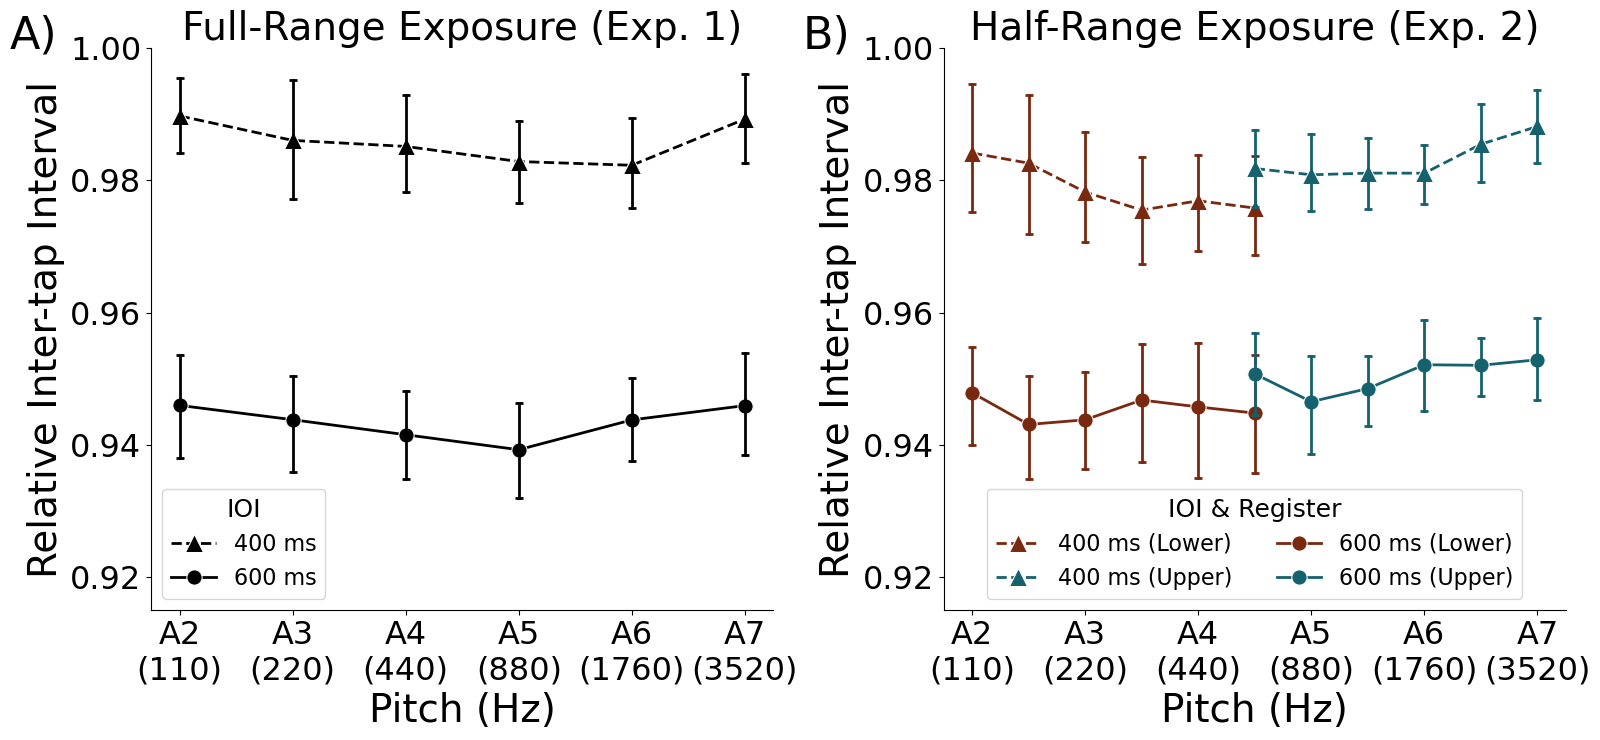

In [28]:
###
# CONTINUATION
###

plt.subplot(121)

# Plot data
d = iti_means[(iti_means.register=='B') & (iti_means.ioi=='400')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=text_color, ls='--', marker='^', lw=2, ms=13, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms')
d = iti_means[(iti_means.register=='B') & (iti_means.ioi=='600')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=text_color, ls='-', marker='o', lw=2, ms=11, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label= '600 ms')

# Formatting
plt.text(27, 1, 'A)', fontsize=32)
plt.title('Full-Range Exposure (Exp. 1)')
plt.legend(loc='lower left', title='IOI')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Relative Inter-tap Interval')
plt.ylim(.915, 1)


plt.subplot(122)

# Plot data
d = iti_means[(iti_means.register=='L') & (iti_means.ioi=='400')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=color1, ls='--', marker='^', ms=13, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms (Lower)')
d = iti_means[(iti_means.register=='U') & (iti_means.ioi=='400')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=color2, ls='--', marker='^', ms=13,  lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='400 ms (Upper)')

d = iti_means[(iti_means.register=='L') & (iti_means.ioi=='600')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=color1, ls='-', marker='o', ms=11, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='600 ms (Lower)')
d = iti_means[(iti_means.register=='U') & (iti_means.ioi=='600')]
sns.lineplot(x='pitch', y='rel_iti', data=d, color=color2, ls='-', marker='o', ms=11, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='600 ms (Upper)')

# Formatting
plt.text(27, 1, 'B)', fontsize=32)
plt.title('Half-Range Exposure (Exp. 2)')
plt.legend(loc='lower center', title='IOI & Register', ncol=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Relative Inter-tap Interval')
plt.ylim(.915, 1)


plt.gcf().set_size_inches(16, 7.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'rel_iti.svg')
plt.savefig(FIGURE_PATH + 'rel_iti.pdf')

# Spontaneous Motor Tempo

In [30]:
subj_smeans = sdata.groupby(['subject','register'])[['perc_async', 'smt']].mean().reset_index()
subj_cmeans = cdata.groupby(['subject','register'])[['rel_iti', 'smt']].mean().reset_index()

In [31]:
print(np.mean(subj_smeans[subj_smeans.register=='B'].smt), np.mean(subj_smeans[subj_smeans.register=='L'].smt), np.mean(subj_smeans[subj_smeans.register=='U'].smt))
print(np.std(subj_smeans[subj_smeans.register=='B'].smt), np.std(subj_smeans[subj_smeans.register=='L'].smt), np.std(subj_smeans[subj_smeans.register=='U'].smt))

620.4892636099532 557.5528017241379 501.39301108374383
203.73955716495774 271.19950868154825 156.76990169047855


In [32]:
subj_smeans.smt.max()

1643.2068965517242

PearsonRResult(statistic=0.041421194446192064, pvalue=0.7032576670204469)
PearsonRResult(statistic=0.10483867774756224, pvalue=0.33384762282887925)


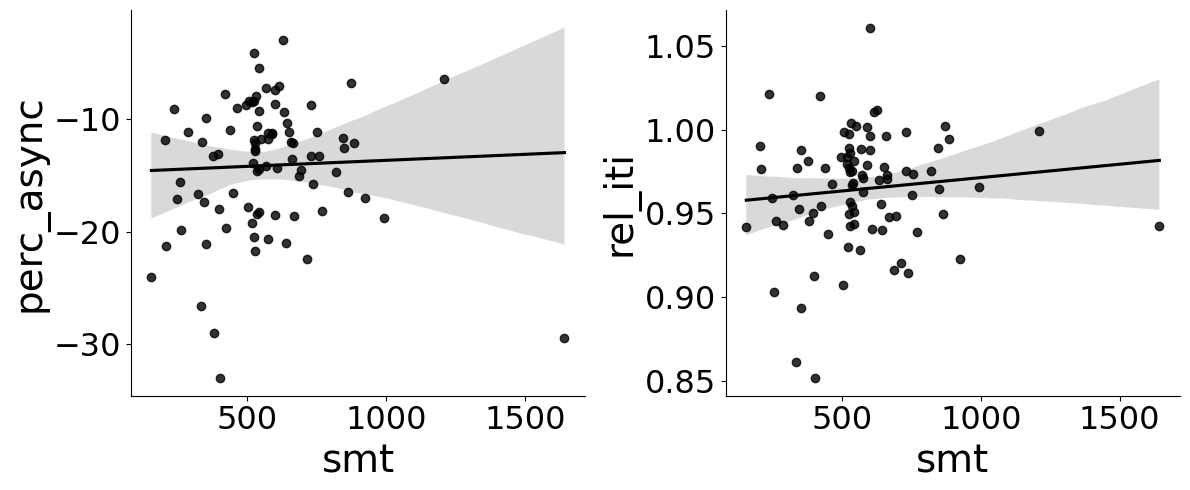

In [33]:
plt.subplot(121)
sns.regplot(x='smt', y='perc_async', data=subj_smeans, color='k')
print(stats.pearsonr(subj_smeans.smt, subj_smeans.perc_async))

plt.subplot(122)
sns.regplot(x='smt', y='rel_iti', data=subj_cmeans, color='k')
print(stats.pearsonr(subj_cmeans.smt, subj_cmeans.rel_iti))

plt.gcf().set_size_inches(12, 5)
plt.tight_layout()

# Musicianship

In [35]:
mus_exp = sdata.groupby(['subject', 'register']).years_lessons.mean().reset_index()
med_exp = np.median(mus_exp.years_lessons)
exper_subj = mus_exp[mus_exp.years_lessons > med_exp].subject

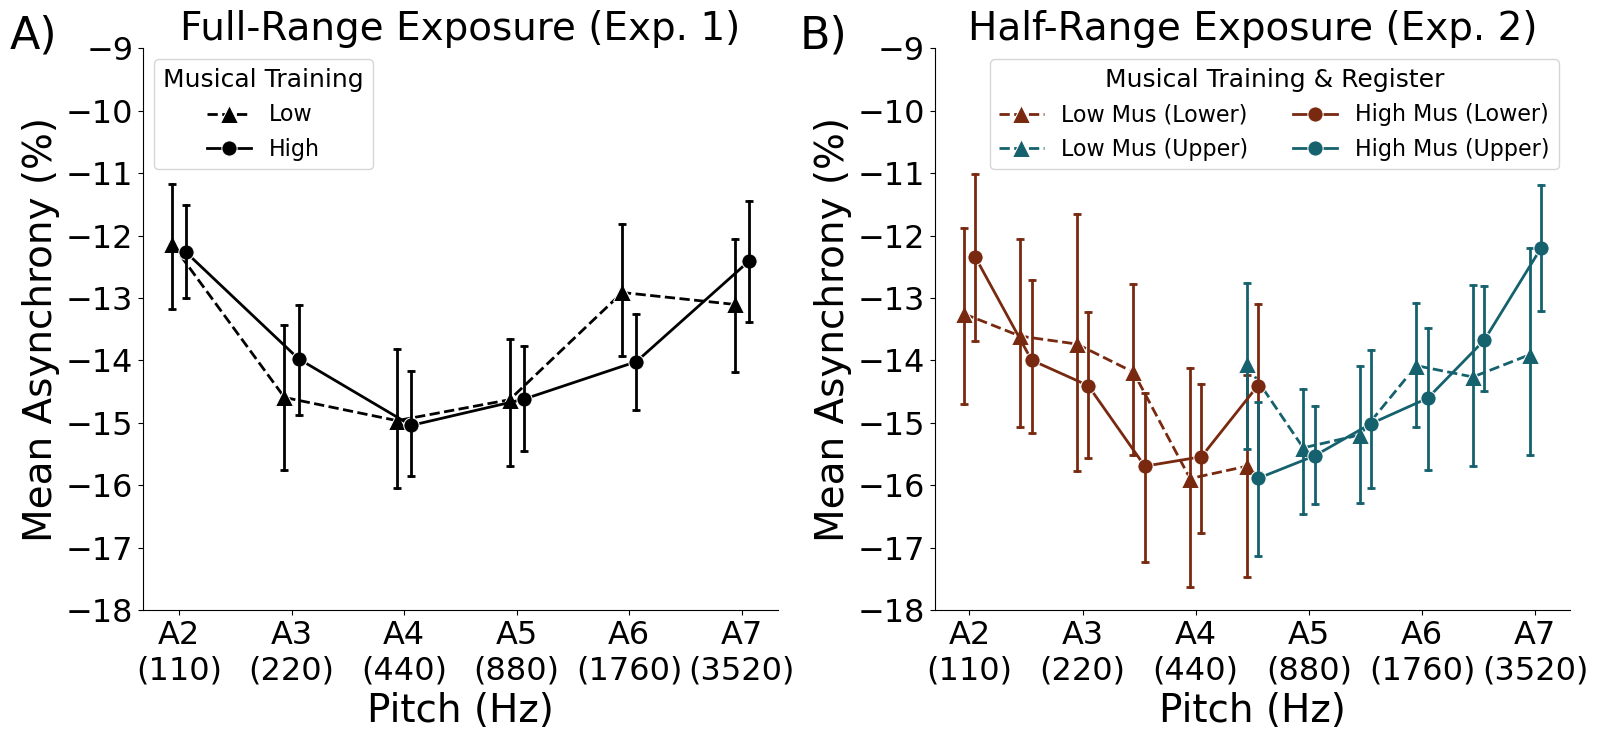

In [36]:
###
# SYNCHRONIZATION
###

plt.subplot(121)

# Plot data
d = async_means[(async_means.register=='B') & ~np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.75, y='perc_async', data=d, color=text_color, ls='--', marker='^', lw=2, ms=13, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low')
d = async_means[(async_means.register=='B') & np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.75, y='perc_async', data=d, color=text_color, ls='-', marker='o', lw=2, ms=11, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='High')

# Formatting
plt.text(27, -9, 'A)', fontsize=32)
plt.title('Full-Range Exposure (Exp. 1)')
plt.legend(loc='upper left', title='Musical Training')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Mean Asynchrony (%)')
plt.ylim(-18, -9)
plt.yticks(np.arange(-18, -8, 1))


plt.subplot(122)

# Plot data
d = async_means[(async_means.register=='L') & ~np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.6, y='perc_async', data=d, color=color1, ls='--', marker='^', ms=13, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low Mus (Lower)')
d = async_means[(async_means.register=='U') & ~np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.6, y='perc_async', data=d, color=color2, ls='--', marker='^', ms=13, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low Mus (Upper)')
d = async_means[(async_means.register=='L') & np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.6, y='perc_async', data=d, color=color1, ls='-', marker='o', ms=11, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='High Mus (Lower)')
d = async_means[(async_means.register=='U') & np.isin(async_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.6, y='perc_async', data=d, color=color2, ls='-', marker='o', ms=11, lw=2,
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='High Mus (Upper)')


# Formatting
plt.text(27, -9, 'B)', fontsize=32)
plt.title('Half-Range Exposure (Exp. 2)')
plt.legend(loc='upper right', title='Musical Training & Register', ncol=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Mean Asynchrony (%)')
plt.ylim(-18, -9)
plt.yticks(np.arange(-18, -8, 1))


plt.gcf().set_size_inches(16, 7.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'async_mus.svg')
plt.savefig(FIGURE_PATH + 'async_mus.pdf')

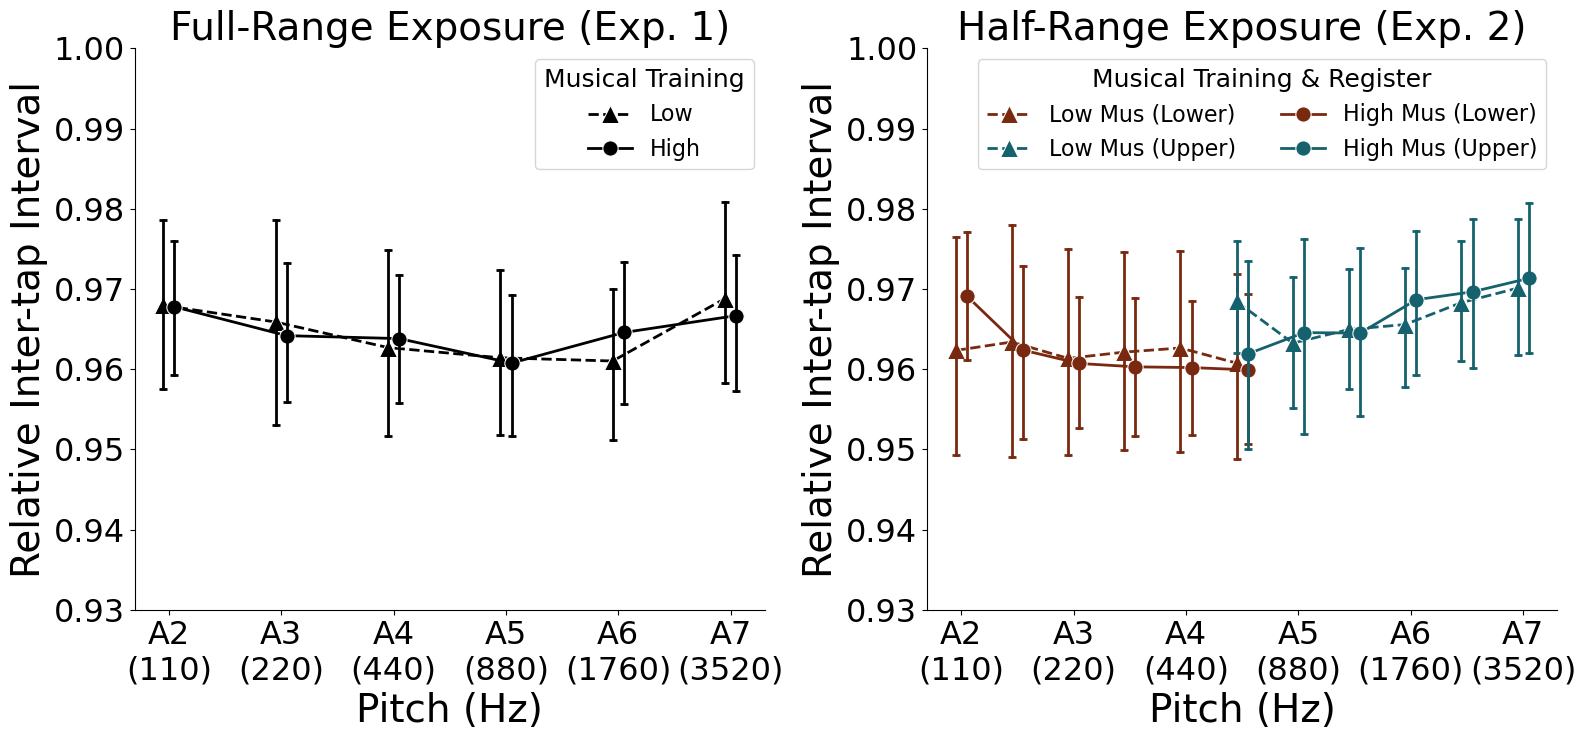

In [37]:
###
# CONTINUATION
###

plt.subplot(121)

# Plot data
d = iti_means[(iti_means.register=='B') & ~np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.6, y='rel_iti', data=d, color=text_color, ls='--', marker='^', lw=2, ms=13, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low')
d = iti_means[(iti_means.register=='B') & np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.6, y='rel_iti', data=d, color=text_color, ls='-', marker='o', lw=2, ms=11, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label= 'High')

# Formatting
#plt.text(27, 1, 'A)', fontsize=32)
plt.title('Full-Range Exposure (Exp. 1)')
plt.legend(title='Musical Training')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Relative Inter-tap Interval')
plt.ylim(.93, 1)


plt.subplot(122)

# Plot data
d = iti_means[(iti_means.register=='L') & ~np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.6, y='rel_iti', data=d, color=color1, ls='--', marker='^', ms=13, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low Mus (Lower)')
d = iti_means[(iti_means.register=='U') & ~np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch-.6, y='rel_iti', data=d, color=color2, ls='--', marker='^', ms=13,  lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='Low Mus (Upper)')

d = iti_means[(iti_means.register=='L') & np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.6, y='rel_iti', data=d, color=color1, ls='-', marker='o', ms=11, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='High Mus (Lower)')
d = iti_means[(iti_means.register=='U') & np.isin(iti_means.subject, exper_subj)]
sns.lineplot(x=d.pitch+.6, y='rel_iti', data=d, color=color2, ls='-', marker='o', ms=11, lw=2, 
             err_style='bars', err_kws=dict(capsize=3, lw=2, capthick=2), label='High Mus (Upper)')

# Formatting
#plt.text(27, 1, 'B)', fontsize=32)
plt.title('Half-Range Exposure (Exp. 2)')
plt.legend(title='Musical Training & Register', ncol=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(45, 106, 12), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Relative Inter-tap Interval')
plt.ylim(.93, 1)


plt.gcf().set_size_inches(16, 7.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'rel_iti_mus.svg')
plt.savefig(FIGURE_PATH + 'rel_iti_mus.pdf')

# Replot data from Pazdera & Trainor (2024)

In [39]:
# Load Experiment 1-3 data
it_data1 = pd.read_csv('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E1/data/response_data.csv')
it_data2 = pd.read_csv('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E2/data/response_data.csv')
it_data3 = pd.read_csv('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E3/data/response_data.csv')

it_excl1 = np.loadtxt('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E1/data/excluded.txt', dtype=int)
it_excl2 = np.loadtxt('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E2/data/excluded.txt', dtype=int)
it_excl3 = np.loadtxt('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E3/data/excluded.txt', dtype=int)

it_data1 = it_data1[~np.isin(it_data1.subject, it_excl1)]
it_data2 = it_data2[~np.isin(it_data2.subject, it_excl2)]
it_data3 = it_data3[~np.isin(it_data3.subject, it_excl3)]

it_data1 = it_data1[it_data1.cooks <= 4 / 90]
it_data2 = it_data2[it_data2.cooks <= 4 / 90]
it_data3 = it_data3[it_data3.cooks <= 4 / 90]

it_data1.loc[:, 'subject'] += 1000
it_data2.loc[:, 'subject'] += 2000
it_data3.loc[:, 'subject'] += 3000

it_data = pd.concat((it_data1, it_data2, it_data3), axis=0, join="outer", ignore_index=True)

# Load Experiment 5 data
itsr_data = pd.read_csv('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E5/data/response_data.csv')
itsr_excl = np.loadtxt('https://raw.githubusercontent.com/jpazdera/IllusoryTempo/main/E5/data/excluded.txt', dtype=int)
itsr_data = itsr_data[~np.isin(itsr_data.subject, itsr_excl)]
itsr_data = itsr_data[itsr_data.cooks <= 4 / 180]

In [40]:
# Adjust scores using Loftus & Masson (1994) method for plotting within-subject confidence intervals
# Experiment 1-3
subj_means = it_data.groupby(['subject', 'pitch']).mean(numeric_only=True).groupby(['subject']).mean().reset_index()
grand_mean = subj_means.mean()
adjusted_scores = it_data.copy()
for i, subj in enumerate(subj_means.subject):
    adjusted_scores.loc[adjusted_scores.subject == subj, 'illusory_tempo'] -= subj_means.illusory_tempo[i] - grand_mean.illusory_tempo
    
# Experiment 5
subj_means2 = itsr_data.groupby(['subject', 'pitch']).mean(numeric_only=True).groupby(['subject']).mean().reset_index()
grand_mean2 = subj_means2.groupby('range').mean().reset_index()

adjusted_scores2 = itsr_data.copy()
for i, subj in enumerate(subj_means2.subject):
    register = subj_means2.range[i]
    adjusted_scores2.loc[adjusted_scores2.subject == subj, 'illusory_tempo'] -= subj_means2.illusory_tempo[i] - grand_mean2.illusory_tempo[register]

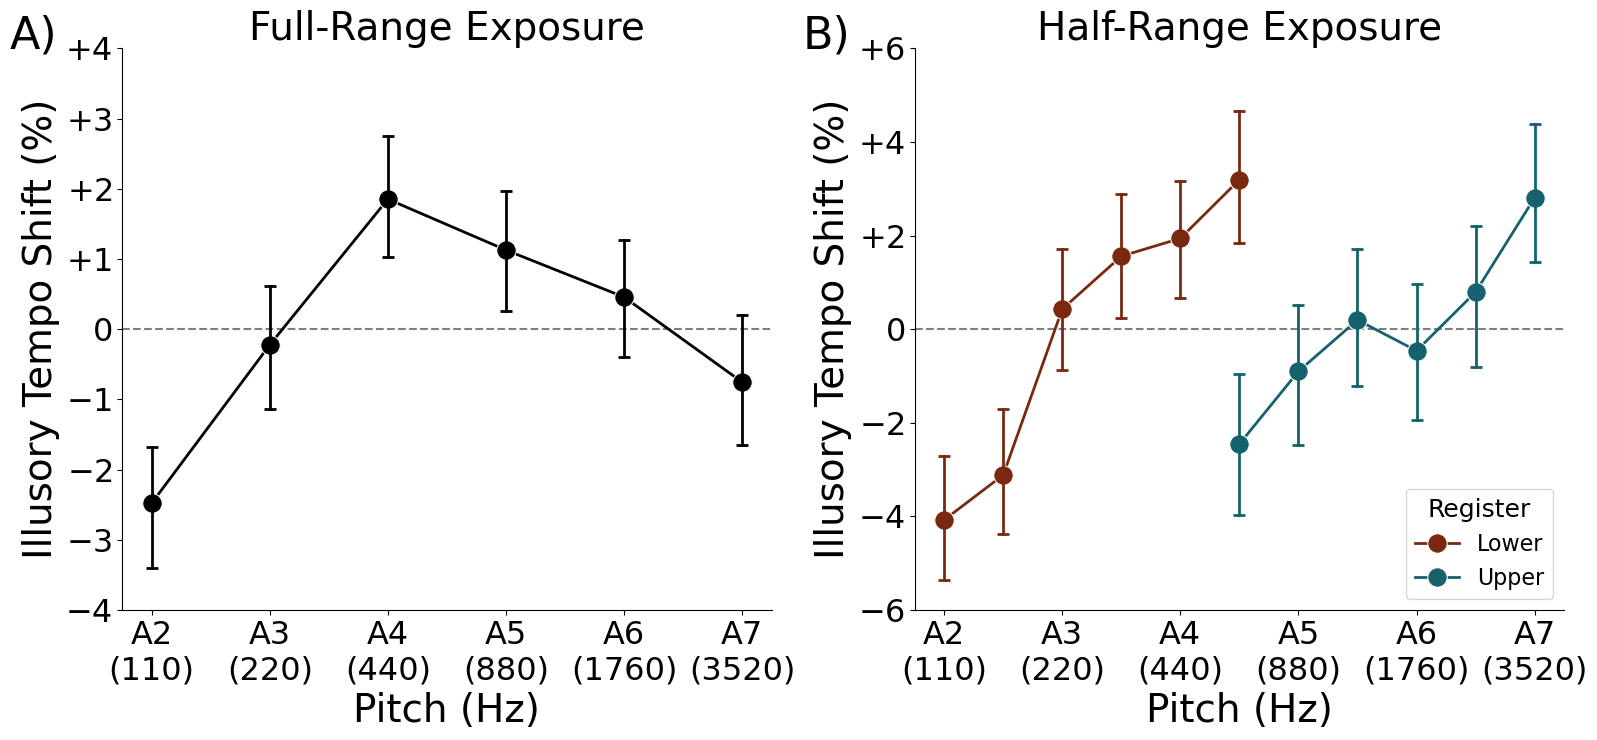

In [41]:
plt.subplot(121)
sns.lineplot(x='pitch', y='illusory_tempo', data=adjusted_scores, color=text_color, 
             ls='-', marker='o', err_style='bars', lw=2, ms=14, err_kws=dict(capsize=4, lw=2, capthick=2))
plt.axhline(0, ls='--', c=text_color, alpha=.5, zorder=0)

# Formatting
plt.text(.8, 4, 'A)', fontsize=32)
plt.title('Full-Range Exposure')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(2, 8), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Illusory Tempo Shift (%)')
plt.ylim(-4, 4)
plt.yticks(np.arange(-4, 5, 1), ['$-4$', '$-3$', '$-2$', '$-1$', '$0$', '$+1$', '$+2$', '$+3$', '$+4$'])

plt.subplot(122)
sns.lineplot(x='pitch', y='illusory_tempo', data=adjusted_scores2[adjusted_scores2.range==0], color=color1,
             ls='-', marker='o', err_style='bars', lw=2, ms=14, err_kws=dict(capsize=4, lw=2, capthick=2), label='Lower')
sns.lineplot(x=adjusted_scores2[adjusted_scores2.range==1].pitch+5, y='illusory_tempo', data=adjusted_scores2[adjusted_scores2.range==1], color=color2,
             ls='-', marker='o', err_style='bars',  lw=2, ms=14, err_kws=dict(capsize=4, lw=2, capthick=2), label='Upper')
plt.axhline(0, ls='--', c=text_color, alpha=.5, zorder=0)

# Formatting
plt.text(-2.4, 6, 'B)', fontsize=32)
plt.title('Half-Range Exposure')
plt.legend(title='Register', loc='lower right')
plt.xlabel('Pitch (Hz)')
plt.xticks(range(0, 11, 2), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3520)'])
plt.ylabel('Illusory Tempo Shift (%)')
plt.ylim(-6, 6)
plt.yticks(np.arange(-6, 7, 2), ['$-6$', '$-4$', '$-2$', '$0$', '$+2$', '$+4$', '$+6$'])

plt.gcf().set_size_inches(16, 7.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'subjective_tempo.svg')
plt.savefig(FIGURE_PATH + 'subjective_tempo.pdf')

# Survey Analysis

Please note that in order to preserve participant privacy, survey responses have not been made open access. Please contact the authors for access to data regarding demographics and musical experience.

In [43]:
SURVEYFILE = '../processed_data/survey_data.csv'

# Load survey data and rename ID to subject
surv = pd.read_csv(SURVEYFILE)
#surv.rename(columns={'id':'subject'}, inplace=True)
surv['subject'] = surv.id.astype(str)

# Get list of subjects included in analyses
subj_list = data.subject.unique()

# Select only survey responses from participants included in analyses
surv = surv[np.in1d(surv.subject, subj_list)]
surv.reset_index()

# Add column indicating whether the participant was in the low or high range condition
surv['register'] = np.array([data[data.subject == s].register.iloc[0] for s in surv.subject])

# Clean age data
age_map = {
    '17 years old': '17',
    '19 years': '19',
    '2003': '20'
}
for i, row in surv.iterrows():
    if row.age in age_map:
        surv.loc[i, 'age'] = age_map[row.age]
surv.age = surv.age.astype(float)

# Print age stats
# Experiment 1
print('EXPERIMENT 1')
print('Minimum Age:', surv[surv.register == 'B'].age.min())
print('Maximum Age:', surv[surv.register == 'B'].age.max())
print('Mean Age:', surv[surv.register == 'B'].age.mean())
print('StdDev Age:', surv[surv.register == 'B'].age.std())
# Experiment 2
print('EXPERIMENT 2')
print('Minimum Age:', surv[surv.register != 'B'].age.min())
print('Maximum Age:', surv[surv.register != 'B'].age.max())
print('Mean Age:', surv[surv.register != 'B'].age.mean())
print('StdDev Age:', surv[surv.register != 'B'].age.std())

for register in ('B', 'L', 'U'):
    print('Register: %s' % register)
    print('Number of Females:', np.sum((surv.gender == 'Female') & (surv.register == register)))
    print('Number of Males:', np.sum((surv.gender == 'Male') & (surv.register == register)))
    print('Number not reported:', np.sum((surv.gender== 'Prefer not to answer') & (surv.register == register)))
    print('Number self-described:', np.sum((surv.gender == 'Other') & (surv.register == register)))

print('Self-descriptions:', [g for g in surv['gender[other]'] if type(g) == str])

EXPERIMENT 1
Minimum Age: 17.0
Maximum Age: 30.0
Mean Age: 18.76923076923077
StdDev Age: 2.169908298590402
EXPERIMENT 2
Minimum Age: 17.0
Maximum Age: 24.0
Mean Age: 18.25
StdDev Age: 1.0619131671036408
Register: B
Number of Females: 32
Number of Males: 6
Number not reported: 1
Number self-described: 0
Register: L
Number of Females: 16
Number of Males: 8
Number not reported: 0
Number self-described: 0
Register: U
Number of Females: 20
Number of Males: 4
Number not reported: 0
Number self-described: 0
Self-descriptions: []
